In [1]:
# Dependancies. Uncomment to automatically install.
# %pip install rosbags
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scipy

In [2]:
import utils.rosbags_converter as rc
from utils.seatrac_enums import CST_E
import utils.plotter_utils as p_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

/home/claytonsmith/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Settings
- RELOAD: If true, converts rosbags. Otherwise assumes rosbags are already converted
- ROSBAGS_DIR: Directory where your rosbags are stored. Can contain multiple bags
- SAVES_DIR: The directory to save converted csv files (to save time reloading)
- VERBOSE: Print non-essential values

- MISSION_KEYWORDS: A list of missions to process. The keyword is a substring of the bag file name that is the same for all bags that were part of the same mission (usually a number "1.0", "2.2", etc). 
- VEHICLE_NAMESPACES: A list of namespaces for the vehicles that were in the missions ("/coug1", "/coug2", etc.)
- VEHICLE_IDS: A list of the beaconIDs for the USBL of each vehicle in the mission (same order as VEHICLE_NAMESPACES). Typically coug1 should have id 1 and coug2 should have id 2 and so on.

In [3]:
RELOAD = False
VERBOSE = False
ROSBAGS_DIR = "../../bag"
SAVES_DIR = ROSBAGS_DIR+"/converted_bags"
ROSMSGS_DIR = "../../cougars-ros2/src"

MISSION_KEYWORDS = ["1.0","2.0","3.0"]
VEHICLE_NAMESPACES = ["/coug1", "/coug2"]
VEHICLE_IDS = [1,2]

In [4]:
# Convert Rosbags
if RELOAD:
    print("converting rosbags")
    dataframes = p_utils.get_dataframes(
        rosbags_dir=ROSBAGS_DIR, rosmsgs_dir=ROSMSGS_DIR, csv_dir=SAVES_DIR,
        keywords=None, topics=None,verbose=VERBOSE)
else:
    print("loading dataframes")
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=None, verbose=VERBOSE)
    if len(dataframes)==0:
        raise RuntimeError("Lenth of dataframes is 0. Dataframes may not be loaded")
print("dataframes loaded")

loading dataframes
dataframes loaded


In [5]:
# converts ros header.stamp.sec and header.stamp.nanosec into pandas Timestamps objects
# and adds a new column "timestamp" to 
p_utils.insert_timestamps(dataframes)

In [6]:
# Reorganize dataframes by mission
# Assumes all vehicles have different namespaces
# Check previous cell output to confirm this is the case
dfsByMission = {}
for keyword in MISSION_KEYWORDS:
    dfsByTopic = {}
    for path, topic_dfs in dataframes.items(): 
        if keyword in path.parts[-1]: # keyword substr of bag file name
            common = set(dfsByTopic.keys()) & set(topic_dfs)
            if common:
                print(RuntimeWarning(f"Warning: mission with keyword {keyword} has multiple topics with same name: {common}"))
            dfsByTopic.update(topic_dfs)
    dfsByMission[keyword] = dfsByTopic
    print(f"{keyword}: {list(dfsByTopic.keys())}")

1.0: ['/coug2/desired_heading', '/coug2/controls/command', '/coug2/controls/debug', '/coug2/fix', '/coug2/dvl/dr_global', '/coug2/odom', '/coug2/leak/data', '/coug2/safety_status', '/coug2/depth_data', '/coug2/battery/data', '/coug2/dvl/velocity', '/coug2/pressure/data', '/coug2/extended_fix', '/coug2/gps_odom', '/coug2/dvl/dead_reckoning', '/coug2/modem_rec', '/coug2/modem_status', '/coug2/modem_imu', '/coug2/desired_depth', '/coug2/kinematics/command', '/tf', '/coug2/desired_speed', '/tf_static']
2.0: ['/modem_rec', '/modem_send', '/modem_status', '/modem_cmd_update', '/coug2/desired_heading', '/coug2/controls/command', '/coug2/controls/debug', '/coug2/fix', '/coug2/dvl/dr_global', '/coug2/odom', '/coug2/leak/data', '/coug2/safety_status', '/coug2/depth_data', '/coug2/battery/data', '/coug2/dvl/velocity', '/coug2/pressure/data', '/coug2/extended_fix', '/coug2/gps_odom', '/coug2/dvl/dead_reckoning', '/coug2/modem_rec', '/coug2/modem_status', '/coug2/modem_imu', '/coug2/desired_depth',

In [7]:
for keyword, topics in dfsByMission.items():
    print(f"--- {keyword} ---")
    bst_modem_status = p_utils.get_topic(topics,'/modem_status',"")
    if bst_modem_status is not None:
        bst_timestamps = bst_modem_status["timestamp"]
        bst_dt = (bst_timestamps.max() - bst_timestamps.min()).seconds
        print(f"basestation:\t{bst_dt}s,\t{bst_timestamps.min()} --- {bst_timestamps.max()}")
    else:
        print("basestation:\tno data")
    for ns in VEHICLE_NAMESPACES:
        modem_status = p_utils.get_topic(topics,'/modem_status',ns)
        if modem_status is not None: 
            timestamps = topics[ns+'/modem_status']['timestamp']
            dt = (timestamps.max() - timestamps.min()).seconds
            print(f"{ns}:\t\t{dt}s,\t{timestamps.min()} --- {timestamps.max()}")
        else:
            print(f"{ns}:\t\tno data")

--- 1.0 ---
basestation:	no data
/coug1:		no data
/coug2:		86s,	2025-04-18 20:04:02.899615665 --- 2025-04-18 20:05:28.980326698
--- 2.0 ---
basestation:	83s,	2025-04-18 20:16:13.234053799 --- 2025-04-18 20:17:36.461428672
/coug1:		no data
/coug2:		402s,	2025-04-18 20:15:52.494259631 --- 2025-04-18 20:22:34.893233573
--- 3.0 ---
basestation:	210s,	2025-04-18 20:40:29.947000119 --- 2025-04-18 20:44:00.812101176
/coug1:		318s,	2025-04-18 20:40:45.269524261 --- 2025-04-18 20:46:04.004334938
/coug2:		210s,	2025-04-18 20:40:50.372179601 --- 2025-04-18 20:44:20.969751531


--- 1.0 ---
no data
--- 2.0 ---


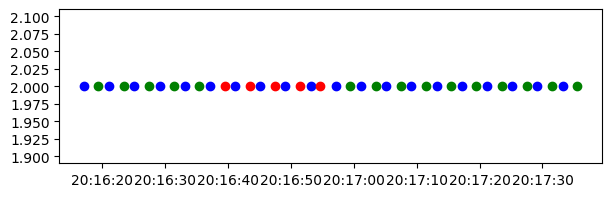

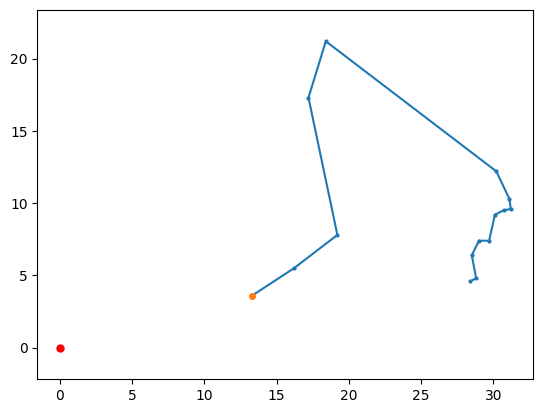

--- 3.0 ---


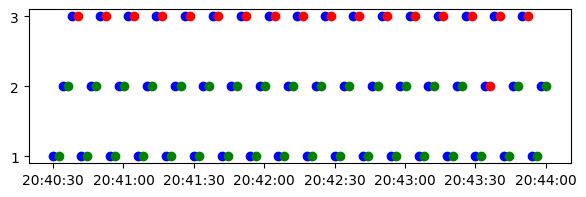

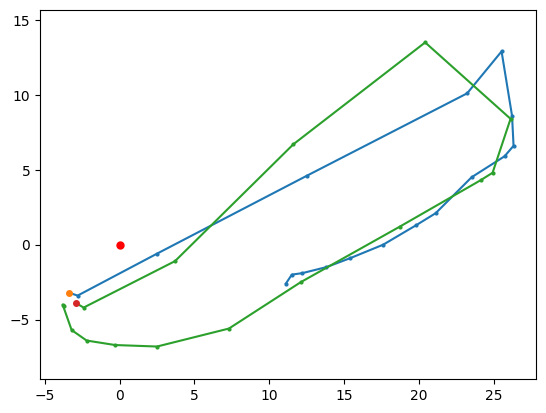

In [8]:
# Base station pings over time + plotted trajectories
for mission, dfsByTopic in dfsByMission.items():
    try:
        print(f"--- {mission} ---")
        bst_rec = dfsByTopic["/modem_rec"]
        bst_cmd = dfsByTopic["/modem_cmd_update"]
        bst_send = bst_cmd[bst_cmd["command_status_code"]==CST_E.CST_OK]
        bst_err = bst_cmd[bst_cmd["command_status_code"]!=CST_E.CST_OK]

        fig, ax = plt.subplots(figsize=(7, 2))
        ax.plot(bst_send["timestamp"], bst_send["target_id"], 'bo')
        ax.plot(bst_rec["timestamp"], bst_rec["src_id"], 'go')
        ax.plot(bst_err["timestamp"], bst_err["target_id"], 'ro')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()

        for bid in range(15):
            modem_from_bid = bst_rec[bst_rec['src_id']==bid]
            if len(modem_from_bid)>0:
                plt.plot(modem_from_bid['position_easting']/10,
                        modem_from_bid['position_northing']/10, 
                        "-o", markersize=2)
                plt.plot(modem_from_bid['position_easting'].iloc[0]/10,
                        modem_from_bid['position_northing'].iloc[0]/10, 
                        "-o", markersize=4)
        plt.plot([0],[0],'ro',markersize=5)
        plt.axis('equal')
        plt.show()
    except KeyError:
        print("no data")

--- 1.0 ---
no data
--- 2.0 ---
/coug1


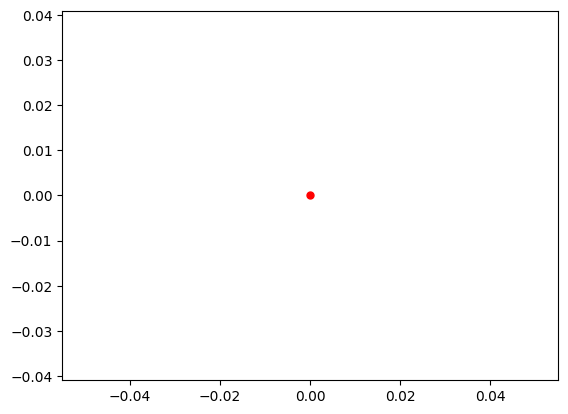

dvl: no data
gps: no data
gps: no data
/coug2


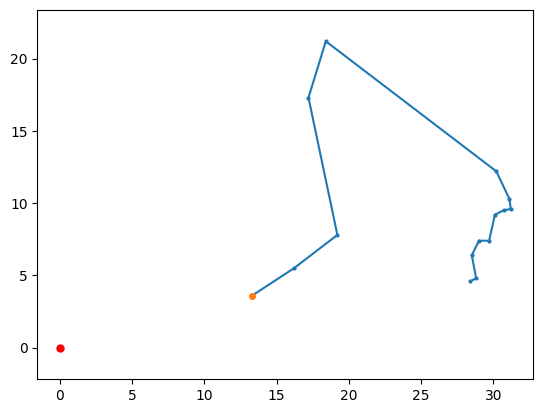

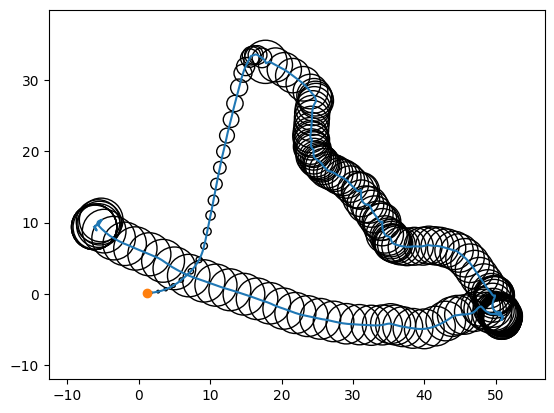

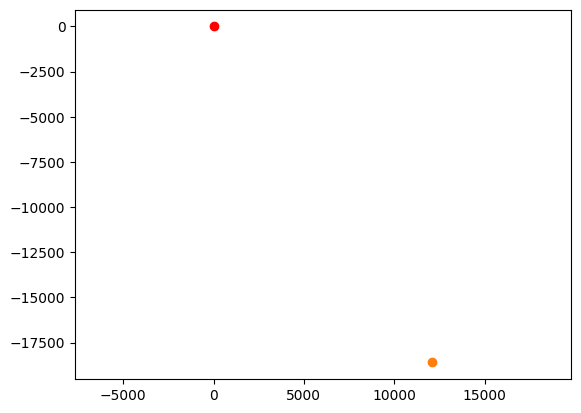

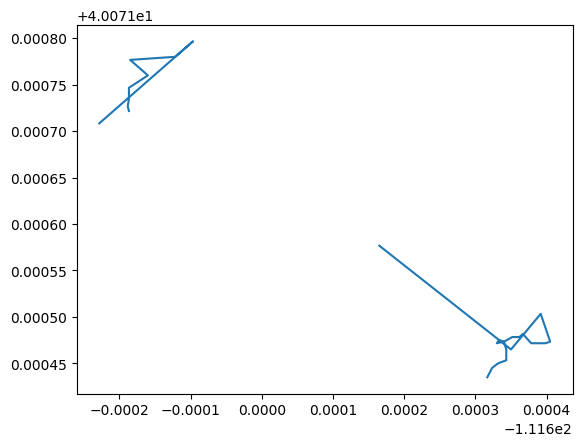

--- 3.0 ---
/coug1


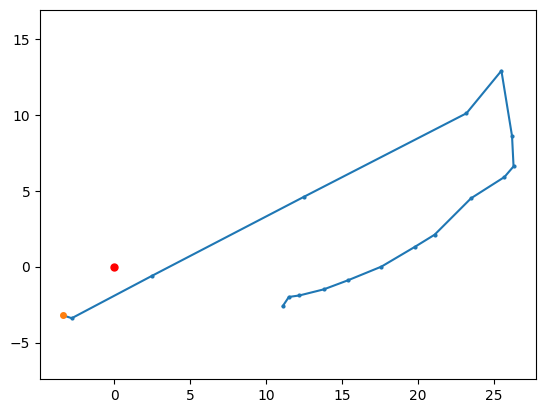

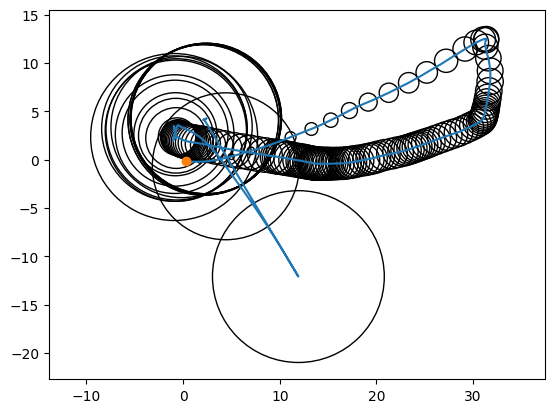

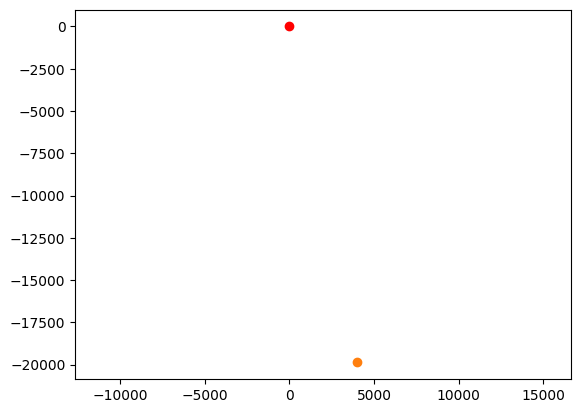

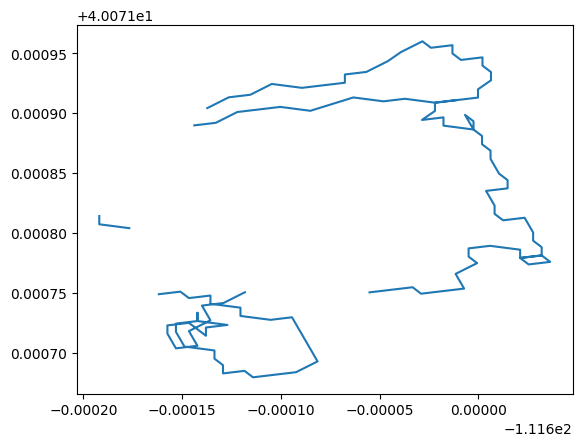

/coug2


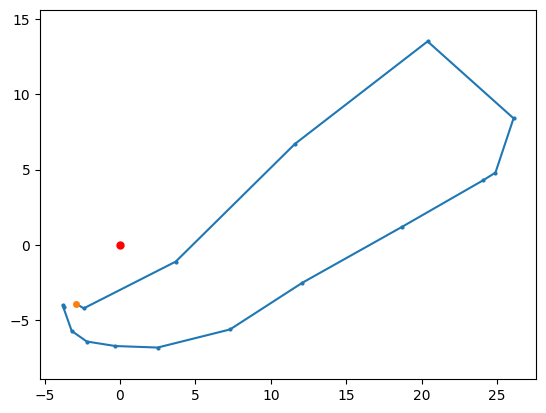

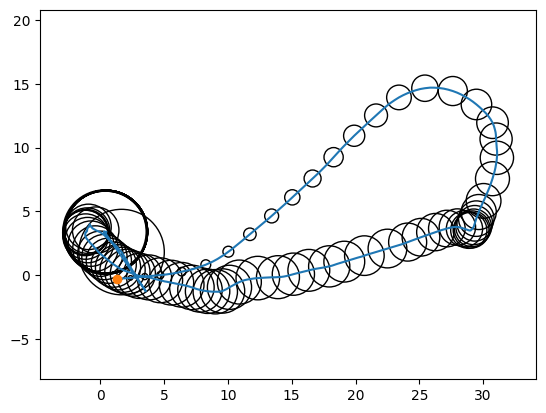

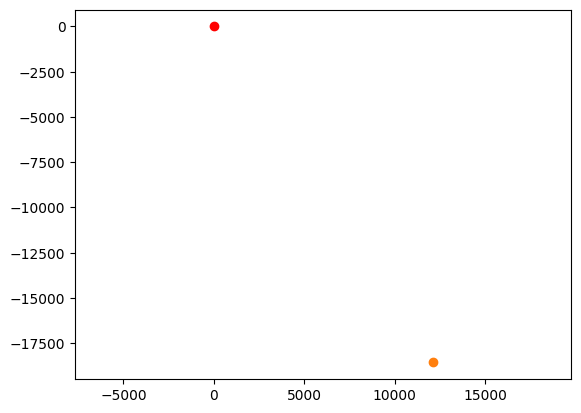

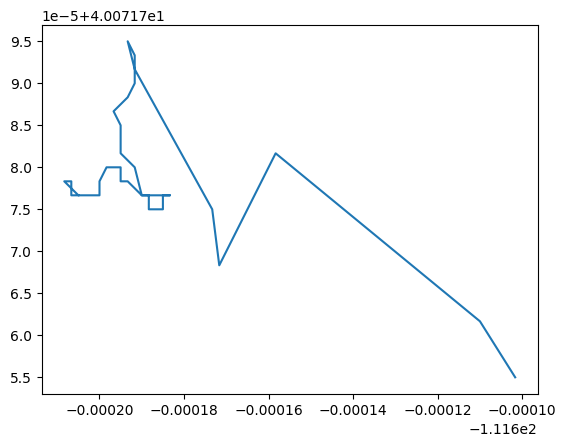

In [9]:
# Plot of dvl and gps against base station modem
for mission, dfsByTopic in dfsByMission.items():
    try:
        print(f"--- {mission} ---")
        bst_rec = dfsByTopic["/modem_rec"]
        for bid, ns in zip(VEHICLE_IDS, VEHICLE_NAMESPACES):
            print(ns)

            modem_from_bid = bst_rec[bst_rec['src_id']==bid]
            if len(modem_from_bid)>0:
                plt.plot(modem_from_bid['position_easting']/10,
                        modem_from_bid['position_northing']/10, 
                        "-o", markersize=2)
                plt.plot(modem_from_bid['position_easting'].iloc[0]/10,
                        modem_from_bid['position_northing'].iloc[0]/10, 
                        "-o", markersize=4)
            plt.plot([0],[0],'ro',markersize=5)
            plt.axis('equal')
            plt.show()

            dvl_odom = p_utils.get_topic(dfsByTopic,'/dvl/dead_reckoning',ns)
            if dvl_odom is not None:
                fig, ax = plt.subplots()
                ax = p_utils.plot_pose_w_cov(dvl_odom, ax=ax)
                plt.show()
            else:
                print("dvl: no data")
            
            gps_odom = p_utils.get_topic(dfsByTopic,'/gps_odom',ns)
            if dvl_odom is not None:
                fig, ax = plt.subplots()
                ax = p_utils.plot_pose_w_cov(gps_odom, ax=ax)
                plt.plot(0,0,'ro')
                plt.show()
            else:
                print("gps: no data")

            gps_fix = p_utils.get_topic(dfsByTopic,'/fix',ns)
            if dvl_odom is not None:
                fig, ax = plt.subplots()
                ax.plot(gps_fix["longitude"], gps_fix["latitude"], '-')
                # ax = p_utils.plot_pose_w_cov(gps_odom, ax=ax)
                plt.show()
            else:
                print("gps: no data")

    except KeyError:
        print("no data")